In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

from textutils import TextUtils

### Check an accuracy of language prediction based on symbols distribution 

In [2]:
languages = !ls 'wiki_data/processed/'
languages

['bulgarian(ru).txt',
 'croatian(hr).txt',
 'czech(cs).txt',
 'danish(da).txt',
 'dutch(en).txt',
 'english(en).txt',
 'french(fr).txt',
 'german(de).txt',
 'italian(it).txt',
 'norwegian(da).txt',
 'polish(pl).txt',
 'romanian(ro).txt',
 'serbian(sr).txt',
 'spanish(es).txt',
 'swedish(sv).txt']

In [59]:
%%time
langs_dicts = {}

for lang in languages:
    lang_name = lang[:-8]
    lang_acr = lang[-7:-5]

    with open('wiki_data/processed/' + lang, 'r') as processed_file:
        text = processed_file.read().replace('\n', '').decode('utf-8')

    normalized_dict = TextUtils.get_normalized_dict (
        TextUtils.get_n_gram_dict(text.encode('utf-8'), 1, lang=lang_acr + '_con')
    )
    ordered_dict = TextUtils.get_ordered_dict(normalized_dict, by='value', reverse=True)

    langs_dicts[lang_name] = ordered_dict

    print lang_name, 'language processed'

bulgarian language processed
croatian language processed
czech language processed
danish language processed
dutch language processed
english language processed
french language processed
german language processed
italian language processed
norwegian language processed
polish language processed
romanian language processed
serbian language processed
spanish language processed
swedish language processed
CPU times: user 13min 15s, sys: 20.6 s, total: 13min 35s
Wall time: 14min 45s


In [142]:
def generate_text_subsamples(n_subsamples = 100, window = 5000):
    data = pd.DataFrame(
        columns=['dict', 'lang', 'lang_predicted', 'guessed']
    )

    for lang in languages:
        lang_name = lang[:-8]
        lang_acr = lang[-7:-5]

        with open('wiki_data/processed/' + lang, 'r') as processed_file:
            text = processed_file.read().replace('\n', '').decode('utf-8')

        for i in range(n_subsamples):
            number_from = np.random.randint(0, high=len(text)-2*window)
            text_sm = text[number_from:number_from + window]

            normalized_dict_sm = TextUtils.get_normalized_dict (
                TextUtils.get_n_gram_dict(text_sm.encode('utf-8'), 1, lang=lang_acr + '_con')
            )
            ordered_dict_sm = TextUtils.get_ordered_dict(normalized_dict_sm, by='value', reverse=True)

            data.loc[len(data)-1] = [ordered_dict_sm, lang_name, '', 0]

    data.reset_index(drop=True, inplace=True)
    data.guessed = data.guessed.astype(np.int16)
    return data

def predict_text_language(distr_dict):
    minimum_dist = np.inf
    predicted_lang = ''
    item = np.array(distr_dict)[:,1].astype(np.float64)    
    
    for lang in langs_dicts:
        corpus = np.array(langs_dicts[lang])[:,1].astype(np.float64)
        l1_dist = TextUtils.l1_distance(corpus, item)
        if l1_dist < minimum_dist:
            minimum_dist = l1_dist
            predicted_lang = lang

    return predicted_lang

In [133]:
%%time
text_subsamples = generate_text_subsamples(n_subsamples=100, window=5000)
text_subsamples['lang_predicted'] = text_subsamples['dict'].apply(predict_text_language)
text_subsamples.guessed = text_subsamples.apply(lambda row: 1 if row['lang'] == row['lang_predicted'] else 0, axis=1)

CPU times: user 15.4 s, sys: 6.86 s, total: 22.2 s
Wall time: 23.2 s


In [134]:
text_subsamples.head()

,dict,lang,lang_predicted,guessed
0,"[(т, 0.1392), (н, 0.133), (с, 0.0918), (р, 0.0...",bulgarian,bulgarian,1
1,"[(т, 0.129), (н, 0.1246), (с, 0.0942), (р, 0.0...",bulgarian,bulgarian,1
2,"[(т, 0.115), (н, 0.1064), (р, 0.0974), (с, 0.0...",bulgarian,croatian,0
3,"[(т, 0.1394), (н, 0.1354), (с, 0.0896), (р, 0....",bulgarian,bulgarian,1
4,"[(т, 0.1304), (н, 0.1304), (с, 0.0958), (р, 0....",bulgarian,bulgarian,1


In [135]:
print 'Percentage of guessed languages'
text_subsamples.guessed.sum() / float(len(text_subsamples))

Percentage of guessed languages


0.78466666666666662

Эксперимент показывает различные значения вероятности определения языка фрагмента в зависимости от длины этого фрагмента
```
0.53, window_size = 2500
0.80, window_size = 5000
0.88, window_size = 10000
0.94, window_size = 25000
```
Более точную зависимость можно посмотреть на графике

In [143]:
%%time
window_sizes = range(2500, 50000, 2500)
probas = []

for window in window_sizes:
    text_subsamples = generate_text_subsamples(n_subsamples=100, window=window)
    text_subsamples['lang_predicted'] = text_subsamples['dict'].apply(predict_text_language)
    text_subsamples.guessed = text_subsamples.apply(lambda row: 1 if row['lang'] == row['lang_predicted'] else 0, axis=1)
    probas.append(text_subsamples.guessed.sum() / float(len(text_subsamples)))

CPU times: user 6min 46s, sys: 1min 48s, total: 8min 35s
Wall time: 8min 41s


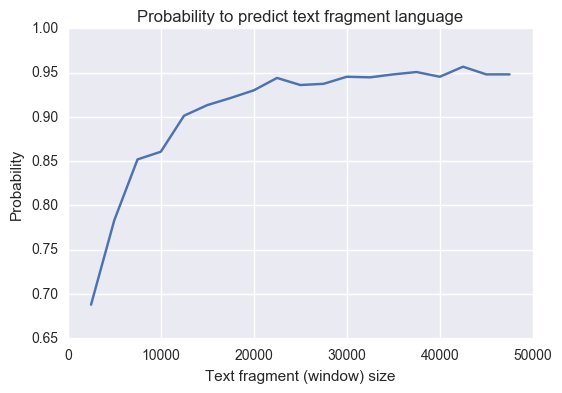

In [144]:
plt.title('Probability to predict text fragment language')
plt.xlabel('Text fragment (window) size')
plt.ylabel('Probability')
plt.plot(window_sizes, probas)
plt.show()

### Test Takahashi transcription

In [145]:
with open('data/takahashi_processed.txt', 'r') as processed_file:
    takahashi = processed_file.read().decode('utf-8')

In [161]:
print len(takahashi)
print takahashi[:1000]

191545
fachysykalarataiinsholshorycthresykorsholdysoryckharorykairchtaiinshararectharcthardansyaiirshekyorykaiinshodcthoarycthesdaraiinsaooiinoteeyoteosrolotycthardaiinotaiinorokandairychearcthaiincpharcfhaiinydaraishyodaroysholcphoyoydarshscfhoaiinshodaryysheyshodyokchoyotcholchocthyoschydainchorkosdaiinshoscfholshodydainosteodyydaincphesaiinolscpheyytainshoshycphodalesokshokshoyotairinoteolokanshodainsckheydaiinshoyckheykodaiincphycphodaiilsctheysheoldainddainoiincholodaiinchodainchdyokaindancthykoddaiinshckheyckeorchorsheykolcholcholkorchalshocholshodankshykchydorchodaiinshokchomychotcheychokainsheopsholdydydcthydaicthyytosholshekodsheycphealydasaindainckhydsdcharshcthaiinokaiircheyrchypotolctholsdloctashokchorcheydainckheyotoldaiiincphoshaiinshokcheeycholtshodeesysheypydeeychyroddoincholdaincthaldarshearkaiindarsheyctharchookaiinshoaiinokoldaiinfarctholdaiinctholdarycheeyokayokydaiinokcheykokaiincholkchydaldeeoshodykosheycthyokcheykeeykeeydalchtoreocholchokchotychoteydchaiinkchsych

In [150]:
takahashi_symbols = {}
for sym in takahashi:
    if sym not in takahashi_symbols:
        takahashi_symbols[sym] = 1
    else:
        takahashi_symbols[sym] += 1

normalized_tak = TextUtils.get_normalized_dict(takahashi_symbols)
ordered_tak = TextUtils.get_ordered_dict(normalized_tak, by='value', reverse=True)

In [184]:
print len(ordered_tak)
ordered_tak

22


[(u'o', 0.1329609230207001),
 (u'e', 0.1047795557179775),
 (u'h', 0.09322091414550106),
 (u'y', 0.0921715523767261),
 (u'a', 0.07455689263619515),
 (u'c', 0.0695084705943773),
 (u'd', 0.06772821008118196),
 (u'i', 0.06124931478242711),
 (u'k', 0.05708319193923099),
 (u'l', 0.05491137852723903),
 (u'r', 0.03892557884570205),
 (u's', 0.03856535017880916),
 (u't', 0.03625257772325041),
 (u'n', 0.03206035135346785),
 (u'q', 0.028311884935654806),
 (u'p', 0.008509749667180036),
 (u'm', 0.005826307134093816),
 (u'f', 0.002636456185230625),
 (u'g', 0.0005011877104596831),
 (u'x', 0.0001827246861050928),
 (u'v', 4.698634785559529e-05),
 (u'z', 1.0441410634576732e-05)]

Пойдем по транскрипции Такахаши с плавающим окном размера 30000 символов (оптимальное значение для стабильного качества предсказания языка) и шагом 1000 символов (примерно 1 страница). Попробуем определить момент смены языка и посмотреть вообще, какие языки наиболее вероятны для этой транскрипции.

In [177]:
window_size = 30000
takahashi_languages = []

for i in range(0, len(takahashi) - window_size, 1000):
    
    current_frame = takahashi[i:i + window_size]
    current_dict = {}

    for sym in current_frame:
        if sym not in current_dict:
            current_dict[sym] = 1
        else:
            current_dict[sym] += 1

    current_norm_dict = TextUtils.get_normalized_dict(current_dict)
    current_ordered_dict = TextUtils.get_ordered_dict(current_norm_dict, by='value', reverse=True)
    takahashi_languages.append(predict_text_language(current_ordered_dict))

In [185]:
print takahashi_languages

['english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'bulgarian', 'bulgarian', 'bulgarian', 'bulgarian', 'bulgarian', 'bulgarian', 'english', 'english', 'english', 'croatian', 'croatian', 'croatian', 'croatian', 'croatian', 'serbian', 'serbian', 'croatian', 'croatian', 'danish', 'danish', 'danish', 'danish', 'danish', 'croatian', 'danish', 'danish', 'english', 'croatian', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'bulgarian', 'bulgarian', 'bulgarian', 'bulgarian', 'bulgarian', 'bulgarian', 'bulgarian', 'bulgarian', 'bulgarian', 'bulgarian', 'bulgarian', 'bulgarian', 'bulgarian', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'english', 'danish', 'english', 'english', 'danish', 'danish', 'danish', 'danish', 'bulgarian', 'bulgarian', 'bulgarian', 'serbian', 'czech', 'czech', 'serbian', 'serbian', 'serb

In [179]:
set(takahashi_languages)

{'bulgarian', 'croatian', 'czech', 'danish', 'english', 'serbian'}

In [181]:
takahashi_langs_dict = {}
for lang in takahashi_languages:
    if lang not in takahashi_langs_dict:
        takahashi_langs_dict[lang] = 1
    else:
        takahashi_langs_dict[lang] += 1

In [182]:
TextUtils.get_ordered_dict(takahashi_langs_dict, by='value', reverse=True)

[('english', 51),
 ('croatian', 49),
 ('bulgarian', 25),
 ('serbian', 19),
 ('danish', 12),
 ('czech', 6)]

Видно, что преимущественно транскрипция Такахаши по распределению символов ближе к тексту, написанному на английском и хорватском языке. Попробуем посмотреть, а насколько по L1 расстоянию отличается фрагмент транскрипции, определенный как английский текст, от истинного английского, а также, насколько отличается истинно-английский фрагмент от распределения всего анлийского текста. Предположительно, что из-за меньшей детерминации текста манускрипта расстояние между фрагментом транскрипции и языком будет меньше, чем между фрагментом языка и языком.

In [197]:
# берем первые `window_size` символов. Этот фрагмент предсказан как английский текст
takahashi_frame = takahashi[:window_size]
frame_dict = {}

corpus = np.array(langs_dicts['english'])[:,1].astype(np.float64)

for sym in takahashi_frame:
    if sym not in frame_dict:
        frame_dict[sym] = 1
    else:
        frame_dict[sym] += 1

frame_norm_dict = TextUtils.get_normalized_dict(frame_dict)
frame_ordered_dict = TextUtils.get_ordered_dict(frame_norm_dict, by='value', reverse=True)
item_tak = np.array(frame_ordered_dict)[:,1].astype(np.float64)

print 'L1-dist: takahashi frame from english language', l1_distance_norm(corpus, item_tak)

with open('wiki_data/processed/english(en).txt', 'r') as processed_file:
    english_frame = processed_file.read().replace('\n', '').decode('utf-8')[:window_size]

english_norm_dict = TextUtils.get_normalized_dict (
    TextUtils.get_n_gram_dict(english_frame.encode('utf-8'), 1, lang='en_con')
)
english_ordered_dict = TextUtils.get_ordered_dict(english_norm_dict, by='value', reverse=True)
item_en = np.array(english_ordered_dict)[:,1].astype(np.float64)

print 'L1-dist: english frame from english language', l1_distance_norm(corpus, item_en)

L1-dist: takahashi frame from english language 0.114309752065
L1-dist: english frame from english language 0.0636542932842


Расстояния отличаются практически в 2 раза, но тем не менее фрагмент траскрипции Такахаши отличается от остальных языков гораздо сильнее. Убедимся в этом:

In [199]:
for lang in langs_dicts:
    corpus = np.array(langs_dicts[lang])[:,1].astype(np.float64)
    print 'L1-dist: takahashi frame from', lang, '\t\t', l1_distance_norm(corpus, item_tak)

L1-dist: takahashi frame from swedish 		0.144794989606
L1-dist: takahashi frame from danish 		0.129431719061
L1-dist: takahashi frame from bulgarian 		0.123744330507
L1-dist: takahashi frame from norwegian 		0.151979492689
L1-dist: takahashi frame from czech 		0.214557755665
L1-dist: takahashi frame from romanian 		0.211263727899
L1-dist: takahashi frame from english 		0.114309752065
L1-dist: takahashi frame from french 		0.241507898348
L1-dist: takahashi frame from spanish 		0.255231600673
L1-dist: takahashi frame from german 		0.127664778783
L1-dist: takahashi frame from serbian 		0.190801882168
L1-dist: takahashi frame from dutch 		0.180086068952
L1-dist: takahashi frame from polish 		0.2276445624
L1-dist: takahashi frame from italian 		0.206400645475
L1-dist: takahashi frame from croatian 		0.190995409313


Также интересно увидеть, что фрагмент английского текста имеет аналогичные порядки расстояний со всеми остальными языками

In [201]:
for lang in langs_dicts:
    corpus = np.array(langs_dicts[lang])[:,1].astype(np.float64)
    print 'L1-dist: english frame from', lang, '\t\t', l1_distance_norm(corpus, item_en)

L1-dist: english frame from swedish 		0.107910463053
L1-dist: english frame from danish 		0.110318348836
L1-dist: english frame from bulgarian 		0.114689390261
L1-dist: english frame from norwegian 		0.102788443543
L1-dist: english frame from czech 		0.280244950112
L1-dist: english frame from romanian 		0.159850500833
L1-dist: english frame from english 		0.0636542932842
L1-dist: english frame from french 		0.183794063204
L1-dist: english frame from spanish 		0.208716973559
L1-dist: english frame from german 		0.102586652006
L1-dist: english frame from serbian 		0.218755877617
L1-dist: english frame from dutch 		0.168701430013
L1-dist: english frame from polish 		0.293857057643
L1-dist: english frame from italian 		0.166356734081
L1-dist: english frame from croatian 		0.227882834411


### Test EVA Transcription 